<a href="https://colab.research.google.com/github/VictoorV/Football_segmentation/blob/main/football_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("ihelon/football-player-segmentation")

print("Path to dataset files:", path)

100%|██████████| 317M/317M [00:05<00:00, 62.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ihelon/football-player-segmentation/versions/1


In [2]:
pip install torchinfo

In [3]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from collections import OrderedDict
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, ToPILImage, Resize, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split
import torch.optim as optim

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Data analysis

In [4]:
!ls /root/.cache/kagglehub/datasets/ihelon/football-player-segmentation/versions/1/

annotations  images


In [5]:
annnotations_path = os.path.join(path, 'annotations')
images_path = os.path.join(path, 'images')

In [6]:
with open('/root/.cache/kagglehub/datasets/ihelon/football-player-segmentation/versions/1/annotations/instances_default.json') as f:
    json_file = json.load(f)

In [7]:
def plot_image_mask_masked(i, plot=False):
  # Get image
  image = cv2.imread(os.path.join(images_path, json_file['images'][i]['file_name']))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_with_boxes = image.copy()
  image_with_mask = image.copy()
  mask = np.zeros(image.shape[:2], dtype=np.uint8) # Black mask

  # Get boxes and mask
  for k in range(len(json_file['annotations'])):
    if json_file['annotations'][k]['image_id'] == json_file['images'][i]['id']:
      bbox = json_file['annotations'][k]['bbox']
      x_min, y_min, w, h = bbox
      x_min = int(x_min)
      y_min = int(y_min)
      x_max = x_min + int(w)
      y_max = y_min + int(h)
      cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=4)

      x_cord = [value for l, value in enumerate(json_file['annotations'][k]['segmentation'][0]) if l%2==0]
      y_cord = [value for l, value in enumerate(json_file['annotations'][k]['segmentation'][0]) if l%2==1]
      points = np.array(list(zip(x_cord, y_cord)), dtype=np.int32)
      cv2.fillPoly(mask, [points], color=(255,255,255)) # White for objects
      cv2.fillPoly(image_with_mask, [points], color=(255,255,255))
  if plot:
    plt.figure(figsize=(30, 25))
    plt.subplot(1, 5, 1), plt.imshow(image), plt.title('Original image')
    plt.subplot(1, 5, 2), plt.imshow(image_with_boxes), plt.title('Image with boxes')
    plt.subplot(1, 5, 3), plt.imshow(mask, cmap='gray'), plt.title('Mask')
    plt.subplot(1, 5, 4), plt.imshow(image_with_mask), plt.title('Image with objects masked')
    plt.subplot(1, 5, 5), plt.imshow(cv2.bitwise_and(image, image, mask=mask)), plt.title('Objects')
    plt.show()
  return(image, mask)

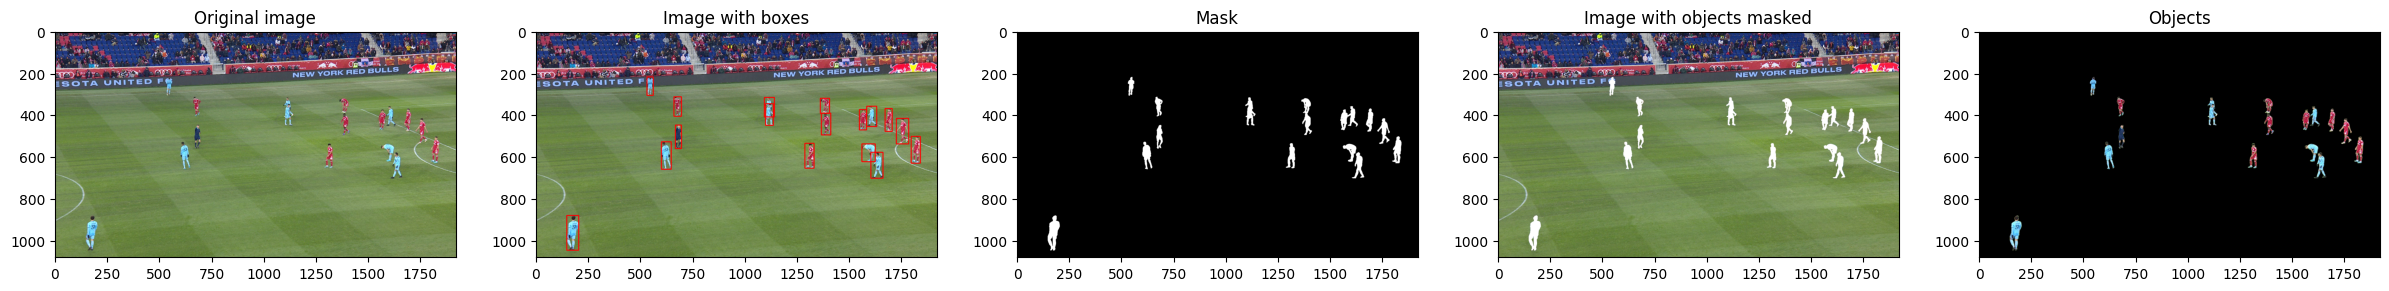

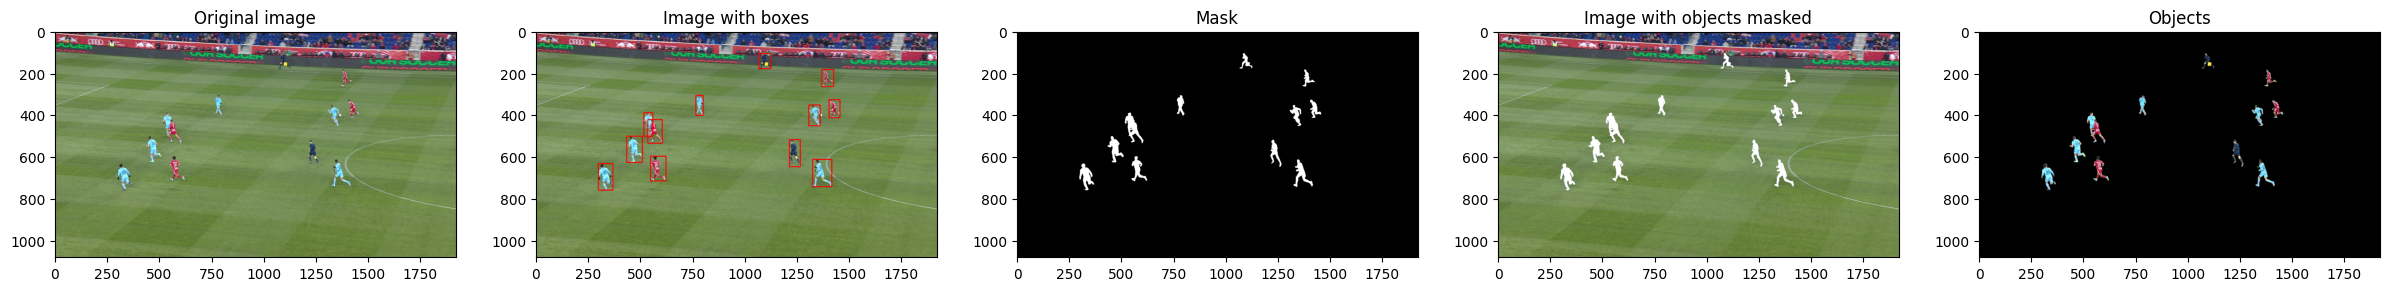

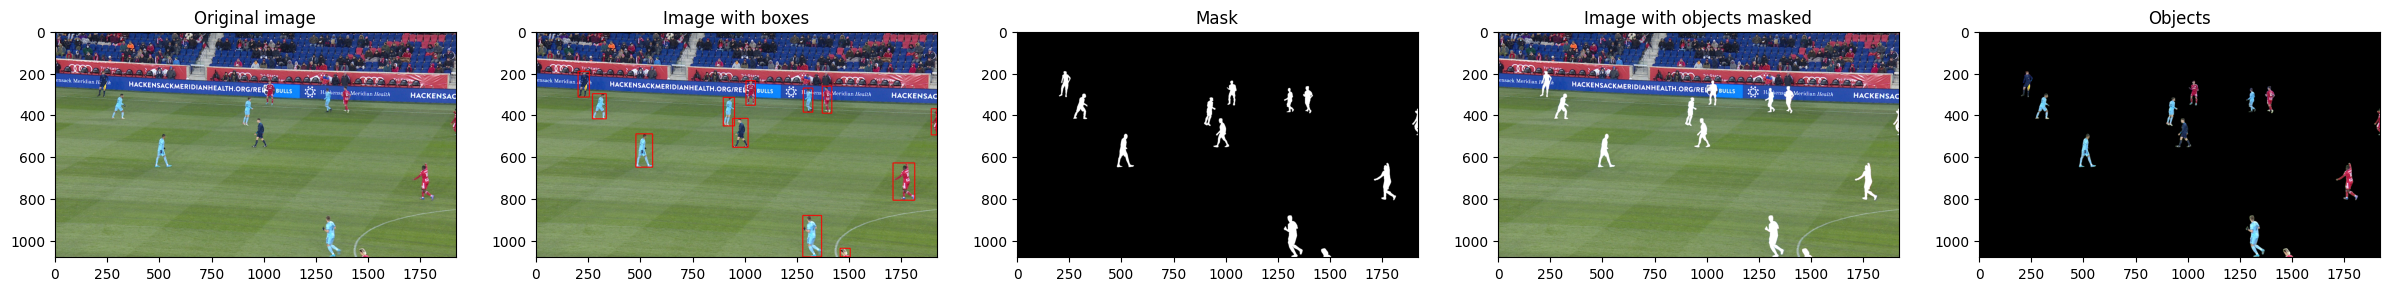

In [8]:
_, _ = plot_image_mask_masked(0, True)
_, _ = plot_image_mask_masked(250, True)
_, _ = plot_image_mask_masked(500, True)

# Making dataset

In [9]:
def get_img_mask(i):
  # Get image
  image = cv2.imread(os.path.join(images_path, json_file['images'][i]['file_name']))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  mask = np.zeros(image.shape[:2], dtype=np.uint8) # Black mask

  # Get boxes and mask
  for k in range(len(json_file['annotations'])):
    if json_file['annotations'][k]['image_id'] == json_file['images'][i]['id']:
      x_cord = [value for l, value in enumerate(json_file['annotations'][k]['segmentation'][0]) if l%2==0]
      y_cord = [value for l, value in enumerate(json_file['annotations'][k]['segmentation'][0]) if l%2==1]
      points = np.array(list(zip(x_cord, y_cord)), dtype=np.int32)
      cv2.fillPoly(mask, [points], color=(255,255,255)) # White for objects
  return(image, mask)

In [10]:
NB_IMG = 512
IMG_SIZE = 512

dataset = []

for i in range(NB_IMG):
  image, mask = get_img_mask(i)
  image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0 # (0,255) -> (0,1)
  mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0 # (0,255) -> (0,1)
  dataset.append([image, mask])
  del image, mask

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            augmented = self.transform(image = img, mask = label)
            img = augmented['image'].to(dtype=torch.float)
            label = (augmented['mask'] > 0.5).to(dtype=torch.float)
        return img, label

In [12]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomSizedCrop(min_max_height=(200, 400), height=IMG_SIZE, width=IMG_SIZE, p=0.5),
    A.CoarseDropout(p=0.5, max_holes=20, max_height=30, max_width=30, min_holes=5, min_height=10, min_width=10),
    #A.Normalize(mean = 0.0, std=1.0), # (0,255) -> (0,1)
    ToTensorV2(),
])

transform_test = A.Compose([
    ToTensorV2(),
])

SEED = 2025
train_set, test_set = train_test_split(dataset, test_size=0.15, random_state=SEED)

train_dataset = CustomDataset(train_set, transform_train)
test_dataset = CustomDataset(test_set, transform_test)

batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

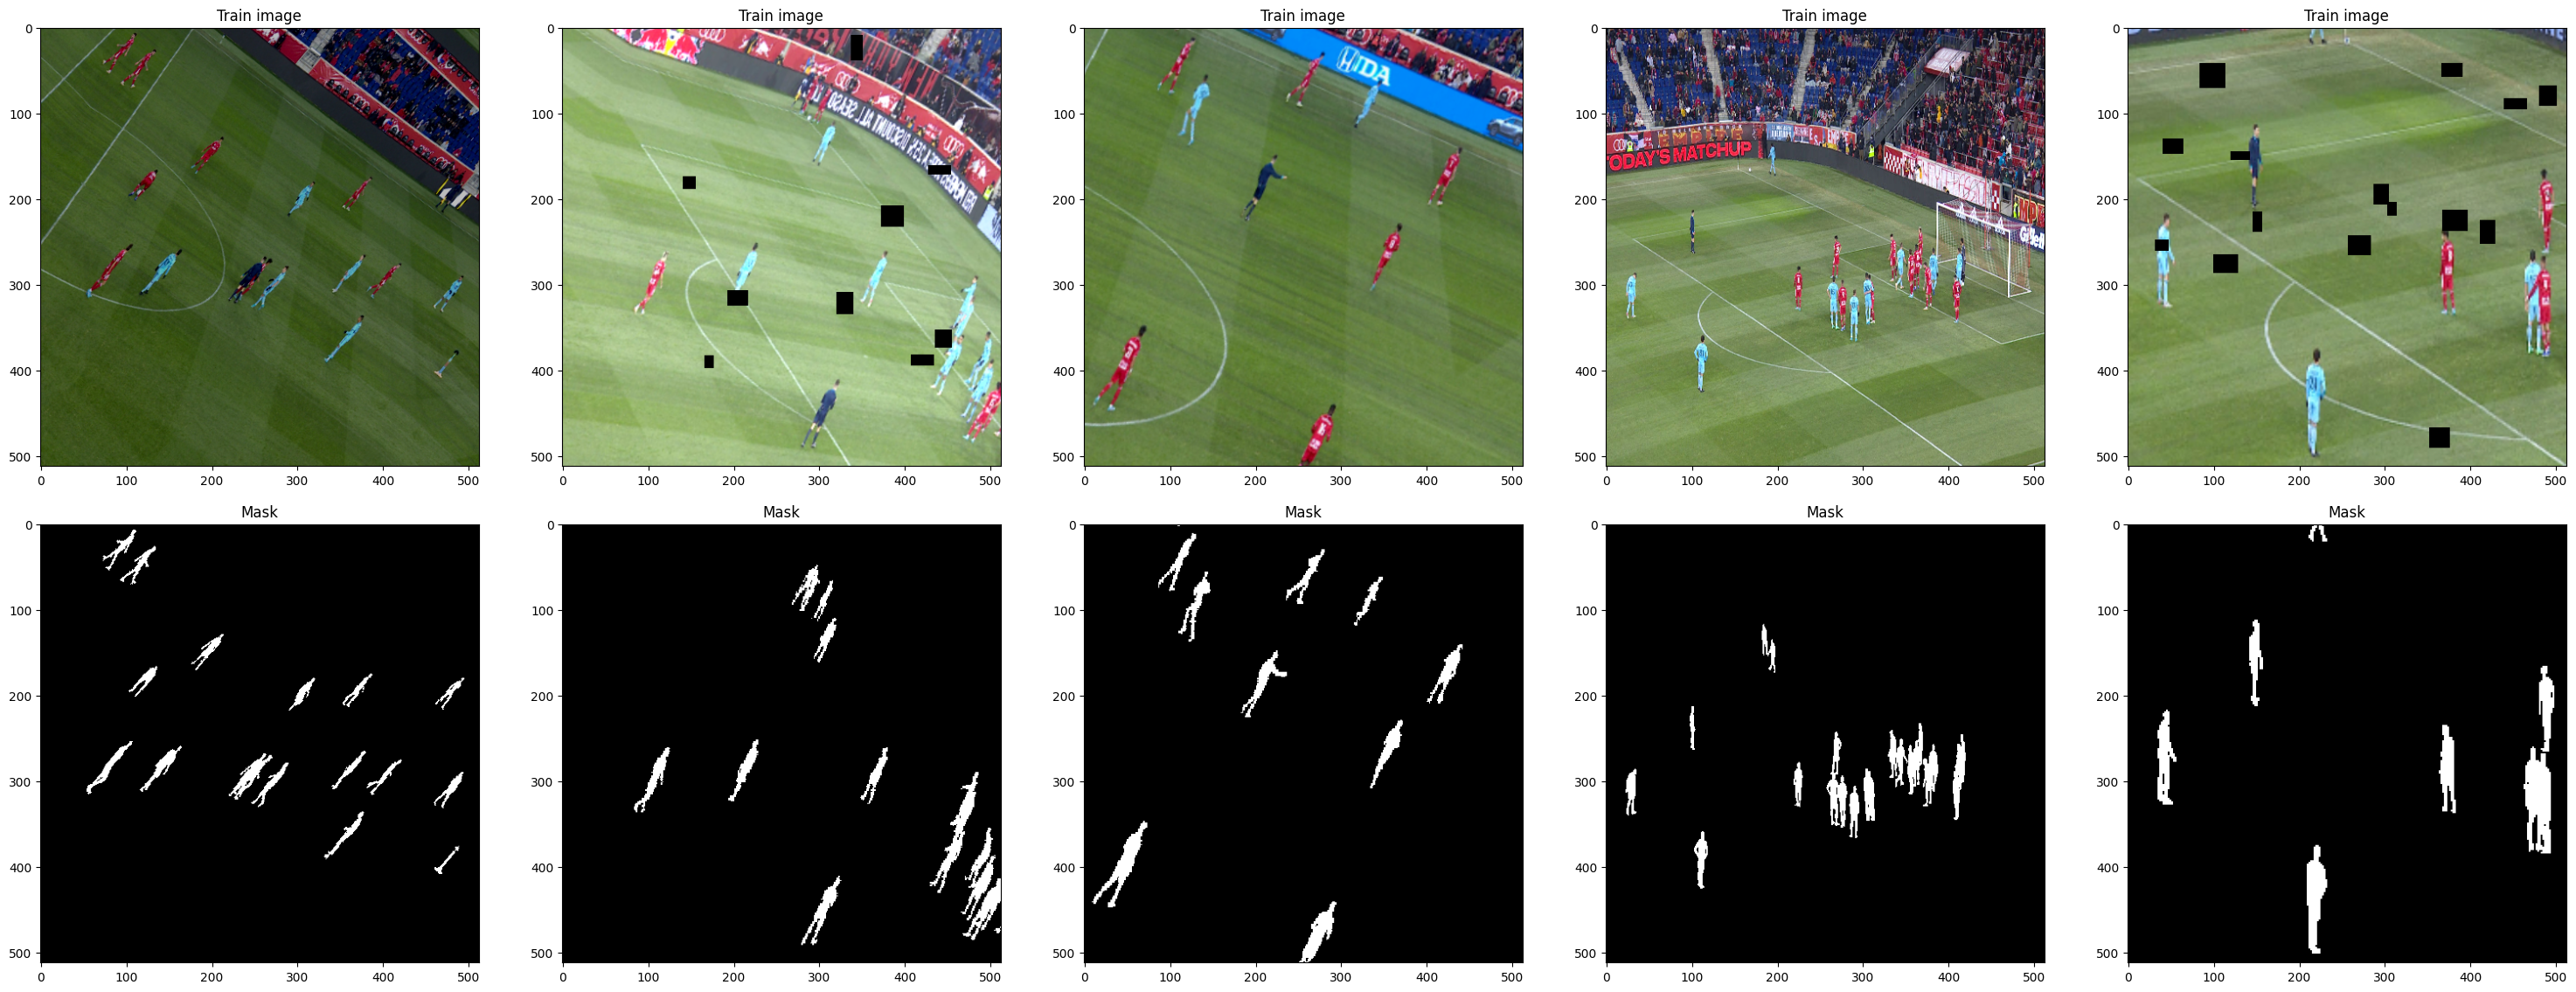

In [13]:
images, labels = next(iter(train_loader))

images = images.numpy()
labels = labels.numpy()

images = np.transpose(images, (0, 2, 3, 1))
labels = np.transpose(labels, (0, 1, 2))


plt.figure(figsize=(30, 25))
for i in range(5):
    img = images[i]
    lbl = labels[i]
    plt.subplot(2, 5, i+1), plt.imshow(img), plt.title('Train image')
    plt.subplot(1, 5, i+1), plt.imshow(lbl, cmap='gray'), plt.title('Mask')

plt.tight_layout()
plt.show()

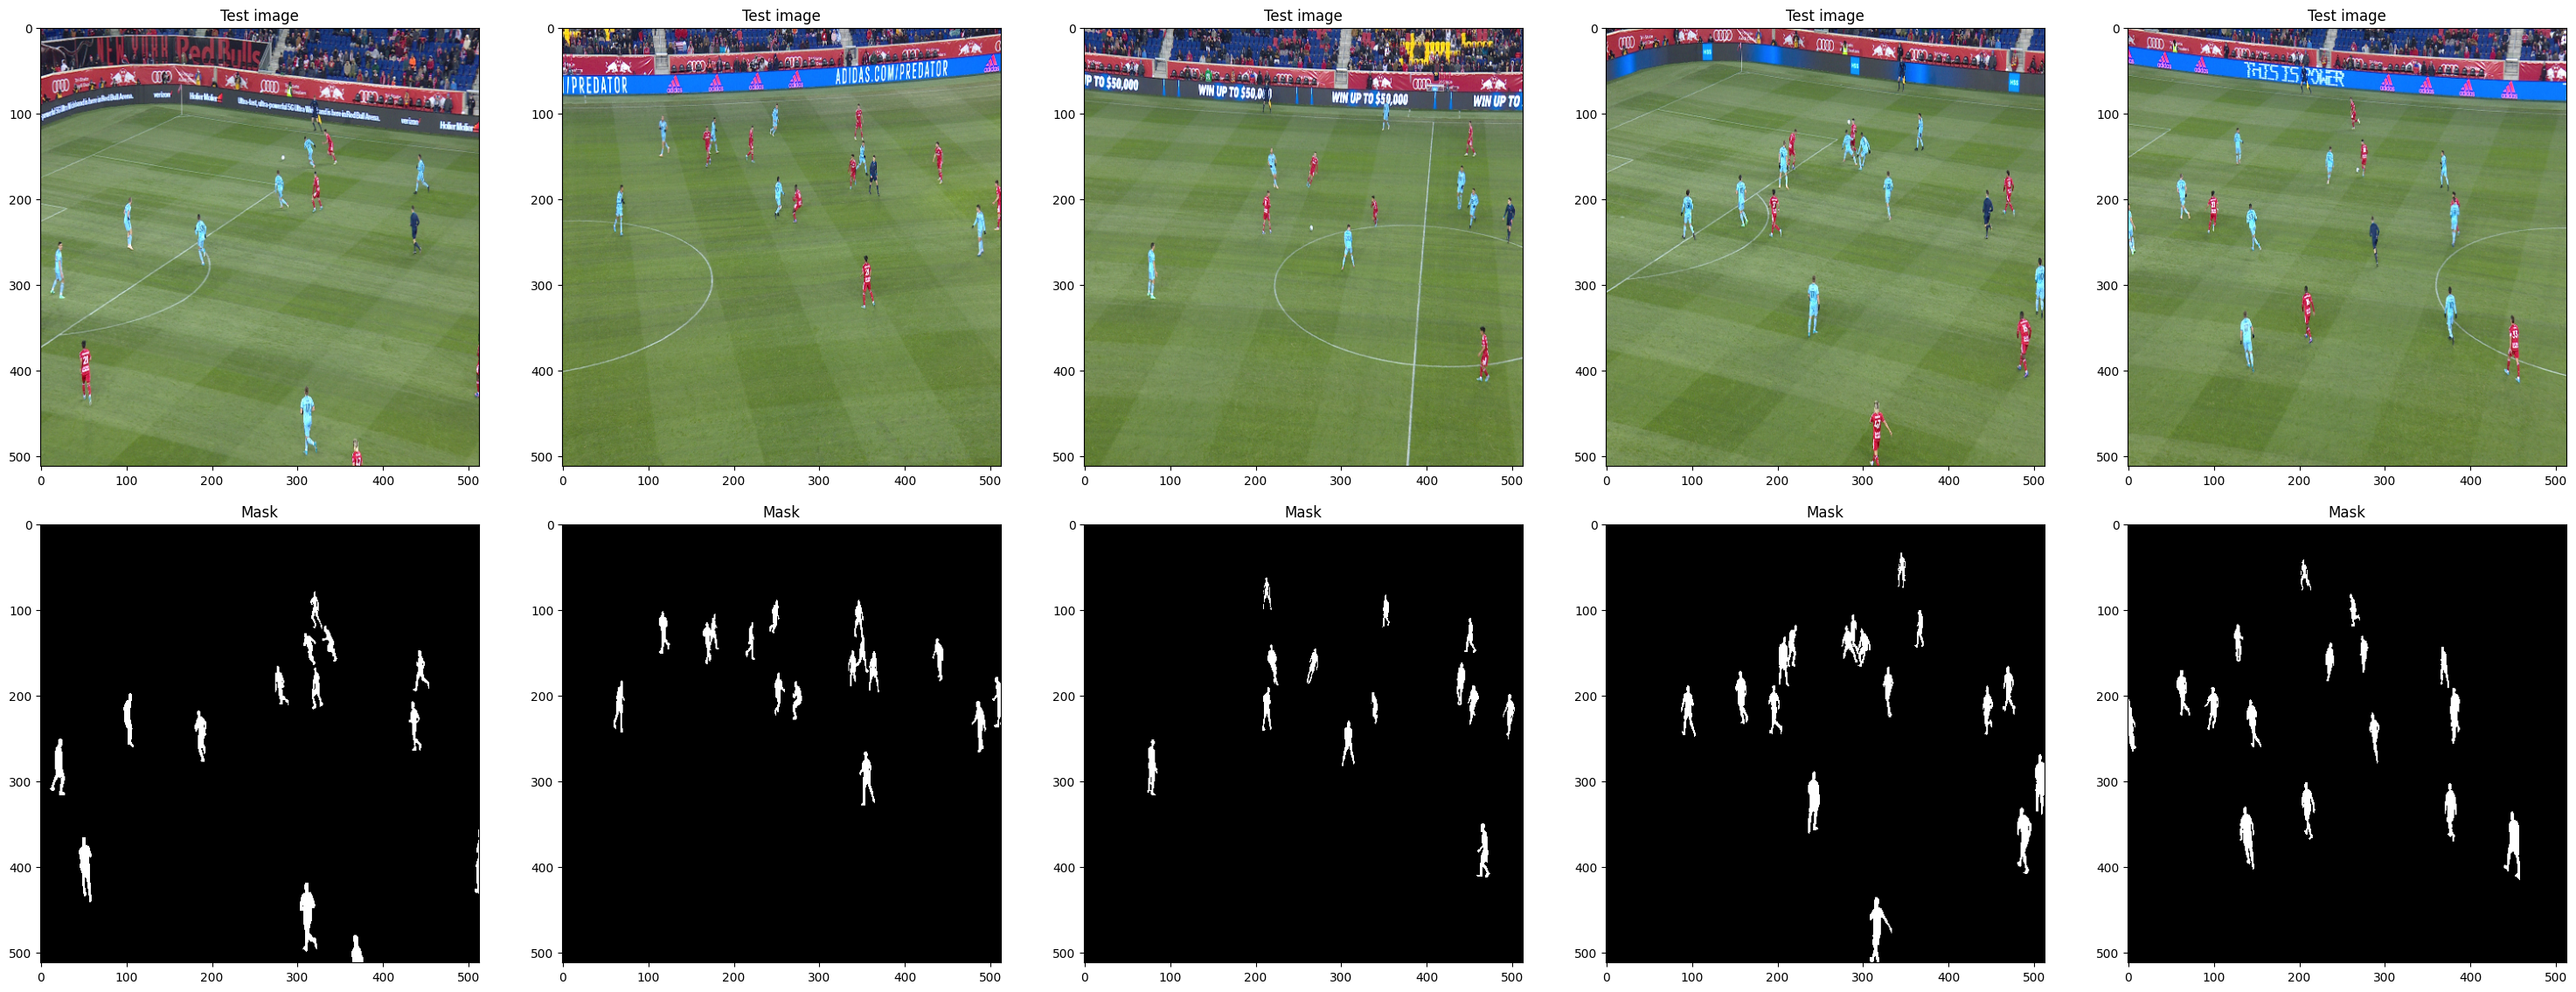

In [14]:
images, labels = next(iter(test_loader))

images = images.numpy()
labels = labels.numpy()

images = np.transpose(images, (0, 2, 3, 1))
labels = np.transpose(labels, (0, 1, 2))


plt.figure(figsize=(30, 25))
for i in range(5):
    img = images[i]
    lbl = labels[i]
    plt.subplot(2, 5, i+1), plt.imshow(img), plt.title('Test image')
    plt.subplot(1, 5, i+1), plt.imshow(lbl, cmap='gray'), plt.title('Mask')

plt.tight_layout()
plt.show()

# U-Net with padding

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
class U_Net(nn.Module): # N*C*H*W
  def __init__(self, in_channels = 3, out_channels = 1):
    super(U_Net, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.encoder1 = self.convolutional_block(self.in_channels, 64, 0.2, 'encoder1') # 512 -> 512
    self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 512 -> 256

    self.encoder2 = self.convolutional_block(64, 128, 0.25, 'encoder2') # 256 -> 256
    self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128

    self.encoder3 = self.convolutional_block(128, 256, 0.3, 'encoder3') # 128 -> 128
    self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64

    self.encoder4 = self.convolutional_block(256, 512, 0.35, 'encoder4') # 64 -> 64
    self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

    self.bottleneck1 = self.convolutional_block(512, 1024, 0.4, 'bottleneck1') # 32 -> 32

    self.up_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0) # 32 -> 64
    self.decoder1 = self.convolutional_block(1024, 512, 0.35, 'decoder1') # 64 -> 64 # CONCAT 512+512

    self.up_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0) # 64 -> 128
    self.decoder2 = self.convolutional_block(512, 256, 0.3, 'decoder2') # 128 -> 128 # CONCAT 256+256

    self.up_conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0) # 128 -> 256
    self.decoder3 = self.convolutional_block(256, 128, 0.25, 'decoder3') # 256 -> 256 # CONCAT 128+128

    self.up_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0) # 256 -> 512
    self.decoder4 = self.convolutional_block(128, 64, 0.2, 'decoder4') # 512 -> 512 # CONCAT 64+64

    self.bottleneck2 = nn.Sequential(OrderedDict([
        ('bottleneck2_conv', nn.Conv2d(in_channels=64, out_channels=self.out_channels, kernel_size=1, padding=0, stride=1, bias=True)),
        ('bottleneck2_softmax', nn.Sigmoid())
    ]))

  def forward(self, x):
    enc1 = self.encoder1(x)
    enc2 = self.encoder2(self.max_pool1(enc1))
    enc3 = self.encoder3(self.max_pool2(enc2))
    enc4 = self.encoder4(self.max_pool3(enc3))

    bottleneck1 = self.bottleneck1(self.max_pool4(enc4))

    dec1 = self.decoder1(torch.cat([enc4, self.up_conv1(bottleneck1)], dim =1))
    dec2 = self.decoder2(torch.cat([enc3, self.up_conv2(dec1)], dim =1))
    dec3 = self.decoder3(torch.cat([enc2, self.up_conv3(dec2)], dim =1))
    dec4 = self.decoder4(torch.cat([enc1, self.up_conv4(dec3)], dim =1))

    output = self.bottleneck2(dec4)
    return output

  @staticmethod
  def convolutional_block(in_channels, out_channels, dropout_prob, name):
    return nn.Sequential(OrderedDict([
        (name + '_conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=True)),
        (name + '_norm1', nn.BatchNorm2d(out_channels)),
        (name + '_relu1', nn.ReLU(inplace=False)),

        (name + '_conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=True)),
        (name + '_norm2', nn.BatchNorm2d(out_channels)),
        (name + '_relu2', nn.ReLU(inplace=False)),
        (name + '_dropout', nn.Dropout2d(p=dropout_prob, inplace=False))
    ]))

In [17]:
model = U_Net()
model.to(device)
print(model)

U_Net(
  (encoder1): Sequential(
    (encoder1_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (encoder1_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder1_relu1): ReLU()
    (encoder1_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (encoder1_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder1_relu2): ReLU()
    (encoder1_dropout): Dropout2d(p=0.2, inplace=False)
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (encoder2_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (encoder2_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder2_relu1): ReLU()
    (encoder2_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (encoder2_norm2): BatchNorm2d(128, eps=

In [18]:
summary(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE))


Layer (type:depth-idx)                   Output Shape              Param #
U_Net                                    [1, 1, 512, 512]          --
├─Sequential: 1-1                        [1, 64, 512, 512]         --
│    └─Conv2d: 2-1                       [1, 64, 512, 512]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 512, 512]         128
│    └─ReLU: 2-3                         [1, 64, 512, 512]         --
│    └─Conv2d: 2-4                       [1, 64, 512, 512]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 512, 512]         128
│    └─ReLU: 2-6                         [1, 64, 512, 512]         --
│    └─Dropout2d: 2-7                    [1, 64, 512, 512]         --
├─MaxPool2d: 1-2                         [1, 64, 256, 256]         --
├─Sequential: 1-3                        [1, 128, 256, 256]        --
│    └─Conv2d: 2-8                       [1, 128, 256, 256]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 256, 256]        256
│

# Modeling

In [19]:
def training(model, loader, historical_loss):
  model.train()
  train_loss = 0.0
  for images, labels in loader:
    labels = labels.unsqueeze(1)
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()
  train_loss = train_loss/len(loader)
  historical_loss.append(train_loss)

def evaluation(model, loader, historical_loss):
  model.eval()
  eval_loss = 0.0
  for images, labels in loader:
    with torch.no_grad():
      labels = labels.unsqueeze(1)
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      eval_loss+=loss.item()
  eval_loss = eval_loss/len(loader)
  historical_loss.append(eval_loss)

In [20]:
params_to_update = list(model.parameters())

epochs = 20

criterion = nn.BCELoss()
optimizer = optim.AdamW(params_to_update, lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

training_loss = []
testing_loss = []

In [21]:
for epoch in range(epochs):
  current_lr = scheduler.get_last_lr()[0]
  training(model, train_loader, training_loss)
  evaluation(model, test_loader, testing_loss)
  print(f"Epoch [{epoch+1}/{epochs}]".center(50, "-"))
  print(f"{'Metric':<20}{'Training':<15}{'Validation':<15}")
  print(f"{'Loss':<20}{training_loss[-1]:<15.4f}{testing_loss[-1]:<15.4f}")
  print(f"{'Learning Rate':<20}{current_lr:.6f}")
  print(f"{'-' * 50}")
  scheduler.step()

  model_name =  str(epoch+1) + "_" + model.__class__.__name__+ "_" + str(IMG_SIZE) + ".pth"
  torch.save(model.state_dict(), model_name)
  print(f"Saving {model_name}")
  print("")

-------------------Epoch [1/20]-------------------
Metric              Training       Validation     
Loss                0.3430         0.1656         
Learning Rate       0.001000
--------------------------------------------------
Saving 1_U_Net_512.pth

-------------------Epoch [2/20]-------------------
Metric              Training       Validation     
Loss                0.1201         0.0819         
Learning Rate       0.000994
--------------------------------------------------
Saving 2_U_Net_512.pth

-------------------Epoch [3/20]-------------------
Metric              Training       Validation     
Loss                0.0670         0.0415         
Learning Rate       0.000976
--------------------------------------------------
Saving 3_U_Net_512.pth

-------------------Epoch [4/20]-------------------
Metric              Training       Validation     
Loss                0.0459         0.0323         
Learning Rate       0.000946
-----------------------------------------------

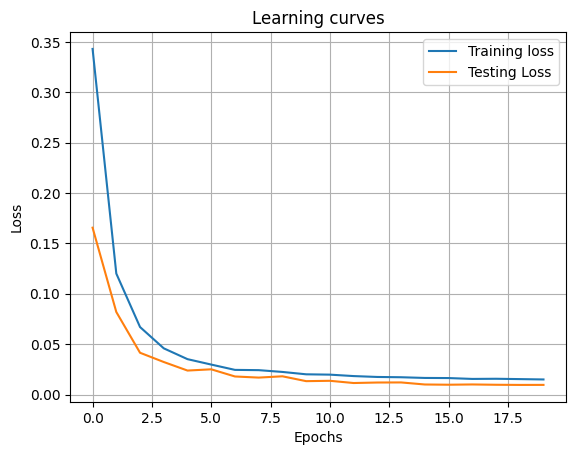

In [64]:
plt.plot(training_loss, label='Training loss')
plt.plot(testing_loss, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Learning curves")
plt.grid()
plt.legend()
plt.show()


# Evaluation

In [42]:
def calculate_iou_batch(predictions, ground_truths, threshold=0.5):
    batch_size = predictions.shape[0]
    channels = predictions.shape[1]
    ious = []

    predictions = (predictions > threshold).astype(int)
    ground_truths = (ground_truths > threshold).astype(int)

    for c in range(channels):
        channel_ious = []

        for i in range(batch_size):
            prediction = predictions[i, c]
            ground_truth = ground_truths[i, c]

            intersection = np.sum(np.logical_and(prediction == 1, ground_truth == 1))
            union = np.sum(np.logical_or(prediction == 1, ground_truth == 1))

            iou = intersection / union if union != 0 else 0.0
            channel_ious.append(iou)

        ious.append(np.mean(channel_ious))

    mean_iou = np.mean(ious)
    return mean_iou


In [44]:
IOU = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.unsqueeze(1)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = outputs > 0.5
        iou = calculate_iou_batch(outputs.cpu().numpy(), labels.cpu().numpy())
        IOU.append(iou)

In [47]:
print(f'IOU = {np.mean(IOU)}')

IOU = 0.8542923255809034


In [48]:
outputs = outputs.cpu().numpy()
labels = labels.cpu().numpy()
images = images.cpu().numpy()

outputs = np.transpose(outputs, (0, 2, 3, 1))
labels = np.transpose(labels, (0, 2, 3, 1))
images = np.transpose(images, (0, 2, 3, 1))

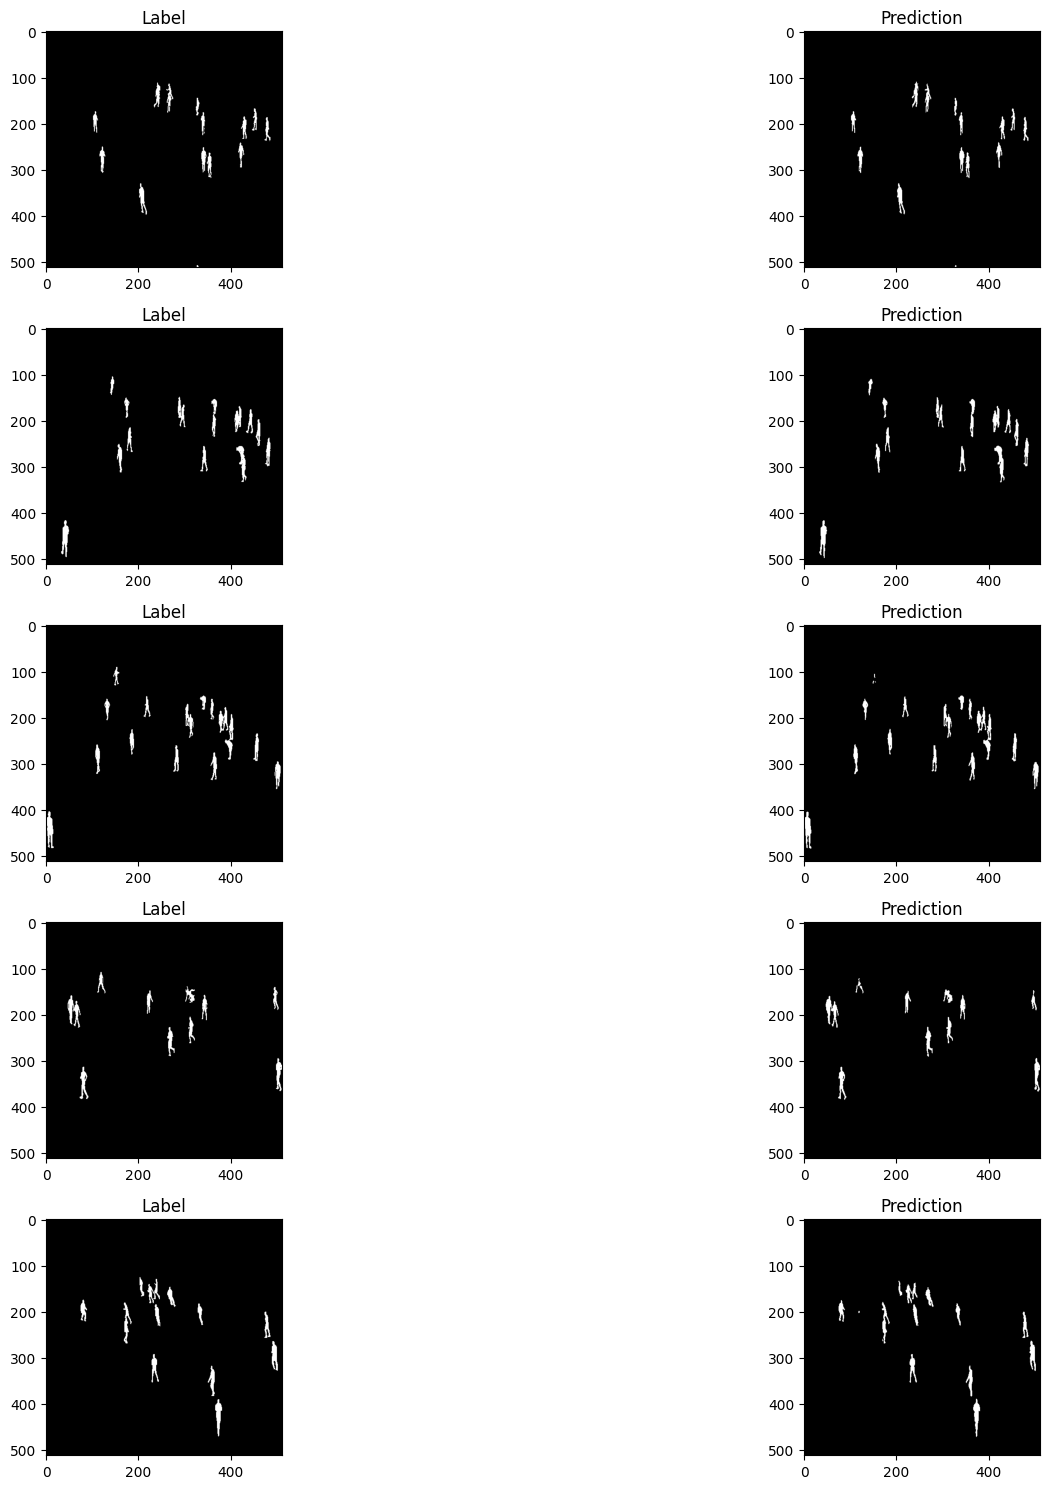

In [72]:
plt.figure(figsize=(20, 15))
for i in range(5):
    pred = outputs[i]
    lbl = labels[i]
    img = images[i]
    plt.subplot(5, 2, 2 * i + 1), plt.imshow(lbl, cmap='gray'), plt.title('Label')
    plt.subplot(5, 2, 2 * i + 2), plt.imshow(pred, cmap='gray'), plt.title('Prediction')

plt.tight_layout()
plt.show()

# Original U-Net with cropping
Problem because of cropped mask

In [45]:
"""class U_Net(nn.Module): # N*C*H*W
  def __init__(self, in_channels = 3, out_channels = 1):
    super(U_Net, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.encoder1 = self.convolutional_block(self.in_channels, 64, 0.2, 'encoder1') # 572 -> 570 -> 568
    self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 568 -> 284

    self.encoder2 = self.convolutional_block(64, 128, 0.25, 'encoder2') # 284 -> 282 -> 280
    self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 280 -> 140

    self.encoder3 = self.convolutional_block(128, 256, 0.3, 'encoder3') # 140 -> 138 -> 136
    self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 136 -> 68

    self.encoder4 = self.convolutional_block(256, 512, 0.35, 'encoder4') # 68 -> 66 -> 64
    self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

    self.bottleneck1 = self.convolutional_block(512, 1024, 0.4, 'bottleneck1') # 32 -> 30 -> 28

    self.up_conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0) # 28 -> 56
    self.decoder1 = self.convolutional_block(1024, 512, 0.35, 'decoder1') # 56 -> 54 -> 52 # CONCAT 512+512

    self.up_conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0) # 52 -> 104
    self.decoder2 = self.convolutional_block(512, 256, 0.3, 'decoder2') # 104 -> 102 -> 100 # CONCAT 256+256

    self.up_conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0) # 100 -> 200
    self.decoder3 = self.convolutional_block(256, 128, 0.25, 'decoder3') # 200 -> 198 -> 196 # CONCAT 128+128

    self.up_conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0) # 196 -> 392
    self.decoder4 = self.convolutional_block(128, 64, 0.2, 'decoder4') # 392 -> 390 -> 388 # CONCAT 64+64

    self.bottleneck2 = nn.Sequential(OrderedDict([
        ('bottleneck2_conv', nn.Conv2d(in_channels=64, out_channels=self.out_channels, kernel_size=1, padding=0, stride=1, bias=True)),
        ('bottleneck2_softmax', nn.Sigmoid())
    ]))

  def forward(self, x):
    enc1 = self.encoder1(x)
    enc2 = self.encoder2(self.max_pool1(enc1))
    enc3 = self.encoder3(self.max_pool2(enc2))
    enc4 = self.encoder4(self.max_pool3(enc3))

    bottleneck1 = self.bottleneck1(self.max_pool4(enc4))

    dec1 = self.decoder1(torch.cat([self.crop(enc4, self.up_conv1(bottleneck1)), self.up_conv1(bottleneck1)], dim =1))
    dec2 = self.decoder2(torch.cat([self.crop(enc3, self.up_conv2(dec1)), self.up_conv2(dec1)], dim =1))
    dec3 = self.decoder3(torch.cat([self.crop(enc2, self.up_conv3(dec2)), self.up_conv3(dec2)], dim =1))
    dec4 = self.decoder4(torch.cat([self.crop(enc1, self.up_conv4(dec3)), self.up_conv4(dec3)], dim =1))

    output = self.bottleneck2(dec4)
    return output

  @staticmethod
  def convolutional_block(in_channels, out_channels, dropout_prob, name):
    return nn.Sequential(OrderedDict([
        (name + '_conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0, stride=1, bias=True)),
        (name + '_norm1', nn.BatchNorm2d(out_channels)),
        (name + '_relu1', nn.ReLU(inplace=True)),

        (name + '_conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0, stride=1, bias=True)),
        (name + '_norm2', nn.BatchNorm2d(out_channels)),
        (name + '_relu2', nn.ReLU(inplace=True)),
        (name + '_dropout', nn.Dropout2d(p=dropout_prob, inplace=True))
    ]))

  @staticmethod
  def crop(encoder_tensor, decoder_tensor): # Images are squares
    _, _ , encoder_height, encoder_width = encoder_tensor.shape
    _, _ , decoder_height, decoder_width = decoder_tensor.shape
    delta_h = (encoder_height - decoder_height) // 2
    delta_w = (encoder_width - decoder_width) //2
    return encoder_tensor[:, :, delta_h:delta_h+decoder_height, delta_w:delta_w+decoder_width]"""